In [321]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

import math
from datetime import datetime, timedelta, time, date
from sklearn.svm import SVR
from sklearn.cluster import KMeans
%matplotlib inline

In [274]:
# 使用一个trick：比较训练集和测试集每天的特征（即每个收费站在每20分钟的流量）的相似度
# 从训练集中选取和测试集合天数中最相近的那一天，作为预测集合
# 进而用选取的训练集的8~10/17~19点的数据作为最终预测集合

In [275]:
# using KNN to predict
train_path = '../dataset/training/volume(table 6)_training.csv'
test_path = '../dataset/testing_phase1/volume(table 6)_test1.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [276]:
# from 9-19 to 10-17
NUM_TRAIN_DAYS = 29

# from 10-18 to 10-24
NUM_TSET_DAYS = 7

In [277]:
train_df.head()

,time,tollgate_id,direction,vehicle_model,has_etc,vehicle_type
0,2016-09-19 23:09:25,2,0,1,0,NaN
1,2016-09-19 23:11:53,2,0,1,0,NaN
2,2016-09-19 23:13:54,2,0,1,0,NaN
3,2016-09-19 23:17:48,1,0,1,1,NaN
4,2016-09-19 23:16:07,2,0,1,0,NaN


In [278]:
test_df.head()

,time,tollgate_id,direction,vehicle_model,has_etc,vehicle_type
0,2016-10-18 07:59:04,2,0,1,1,NaN
1,2016-10-18 07:59:31,2,0,1,1,NaN
2,2016-10-18 07:59:50,2,0,1,1,NaN
3,2016-10-18 07:32:33,3,0,1,1,NaN
4,2016-10-18 07:32:46,3,0,1,1,NaN


In [279]:
def per_20min(dt):
    minute = int(math.floor(dt.minute / 20) * 20)
    second = 0
    dt_new = datetime(dt.year, dt.month, dt.day, dt.hour,minute, 0)
    return dt_new

def select_time(df):
    df.time = pd.to_datetime(df.time)
    df['time'] = df.time.apply(
        per_20min)
    if {'has_etc','vehicle_type', 'vehicle_model'}.issubset(df.columns):
        df = df.drop(['has_etc','vehicle_type', 'vehicle_model'], axis=1)
    df = df.groupby(['tollgate_id', 'direction', 'time']).size()
    df = df.reset_index()
    df = df.rename_axis({0:'volume'}, axis='columns')
    hour = df.time.dt.hour
    df = df.loc[((hour >= 6) & (hour < 10)) 
                     | ((hour >= 15) & (hour < 19))]
    return df

def slice_time(df):
    hour = df.time.dt.hour  
    df_prev2h = df.loc[(((hour >= 6) & (hour < 8)) | ((hour >= 15) & (hour < 17)))]
    df_follow2h = df.loc[(((hour >= 8) & (hour < 10)) | ((hour >= 17) & (hour < 19)))]
    return df_prev2h, df_follow2h

def complete_miss_time(df):
    start_day = df.time.dt.date.values[0]
    end_day = df.time.dt.date.values[-1]
    toll_dire = [(1,0), (1,1), (2,0), (3,0), (3,1)]
    hour_min = [(6,0), (6,20), (6,40), (7,0), (7,20), (7,40),
              (8,0), (8,20), (8,40), (9,0), (9,20), (9,40),
              (15,0), (15,20), (15,40), (16,0), (16,20), (16,40),
              (17,0), (17,20), (17,40), (18,0), (18,20), (18,40)]
    
    df_comp = pd.DataFrame(columns=['tollgate_id','direction','time','volume'])
    for d in range((end_day - start_day).days+1):
        for i in range(len(toll_dire)):
            toll, dire= toll_dire[i]
            for j in range(len(hour_min)):
                h, m = hour_min[j]
                day = start_day + timedelta(days=d)
                day_time = datetime(day.year, day.month, day.day, h, m, 0)
                index = ((df.tollgate_id == toll) & (df.direction == dire) &
                    (df.time == day_time))
                volume = df.loc[index].volume
                if (not volume.empty):
                    v = volume.values[0]
                else:
                    v = np.NaN
                row = {'tollgate_id': toll, 'direction':dire,
                       'time': str(day_time), 'volume':v} 
                df_comp = df_comp.append(row, ignore_index=True)
    
    df_comp['tollgate_id'] = df_comp['tollgate_id'].astype(int)
    df_comp['direction'] = df_comp['direction'].astype(int)
    df_comp.time = pd.to_datetime(df_comp.time)
    df_comp['volume'] = df_comp.volume.fillna(df_comp.volume.mean())
    return df_comp



# 根据KNN分类
def generate_knn_features(df):
    # 分别给月，天，时，分权重...
    features_am = pd.DataFrame(columns=[range(0,30)])
    features_pm = pd.DataFrame(columns=[range(0,30)])
    
    start_day = df.time.dt.date.values[0]
    end_day = df.time.dt.date.values[-1]
    
    for d in range((end_day - start_day).days+1):
        day = start_day + timedelta(days=d)
        day_time_am = [datetime(day.year, day.month, day.day, 6,0,0),
                       datetime(day.year, day.month, day.day, 8,0,0)] 
        day_time_pm = [datetime(day.year, day.month, day.day, 15,0,0),
                       datetime(day.year, day.month, day.day, 17,0,0)] 
        df_volume_am = df.volume.loc[((df.time >= day_time_am[0])
                               & (df.time < day_time_am[1]))]
        df_volume_pm = df.volume.loc[((df.time >= day_time_pm[0])
                               & (df.time < day_time_pm[1]))]
        row_am = list(df_volume_am.values)
        row_pm =list(df_volume_pm.values)
        features_am.loc[d] = row_am
        features_pm.loc[d] = row_pm
    return features_am, features_pm


In [280]:
train_df = select_time(train_df)
test_df = select_time(test_df)

In [281]:
# 数据对比完毕，和官方教程一致
print train_df.shape[0]
train_df.head(10)

3464


,tollgate_id,direction,time,volume
18,1,0,2016-09-19 06:00:00,8
19,1,0,2016-09-19 06:20:00,13
20,1,0,2016-09-19 06:40:00,32
21,1,0,2016-09-19 07:00:00,39
22,1,0,2016-09-19 07:20:00,31
23,1,0,2016-09-19 07:40:00,43
24,1,0,2016-09-19 08:00:00,46
25,1,0,2016-09-19 08:20:00,56
26,1,0,2016-09-19 08:40:00,41
27,1,0,2016-09-19 09:00:00,50


In [282]:
train_df_comp = complete_miss_time(train_df)
test_df_comp = complete_miss_time(test_df)
test_prev2h, none = slice_time(test_df_comp)

In [289]:
print train_df_comp.shape[0]
train_df_comp.head()

3480


,tollgate_id,direction,time,volume
0,1,0,2016-09-19 06:00:00,8.0
1,1,0,2016-09-19 06:20:00,13.0
2,1,0,2016-09-19 06:40:00,32.0
3,1,0,2016-09-19 07:00:00,39.0
4,1,0,2016-09-19 07:20:00,31.0


In [286]:
train_prev2h, train_follow2h = slice_time(train_df_comp)

In [287]:
print train_prev2h.shape[0]
print train_follow2h.shape[0]
train_prev2h.head()
train_follow2h.head(20)

1740
1740


,tollgate_id,direction,time,volume
6,1,0,2016-09-19 08:00:00,46.0
7,1,0,2016-09-19 08:20:00,56.0
8,1,0,2016-09-19 08:40:00,41.0
9,1,0,2016-09-19 09:00:00,50.0
10,1,0,2016-09-19 09:20:00,49.0
11,1,0,2016-09-19 09:40:00,44.0
18,1,0,2016-09-19 17:00:00,36.0
19,1,0,2016-09-19 17:20:00,34.0
20,1,0,2016-09-19 17:40:00,24.0
21,1,0,2016-09-19 18:00:00,29.0


In [290]:
print test_prev2h.shape[0]
test_prev2h.head(20)

420


,tollgate_id,direction,time,volume
0,1,0,2016-10-18 06:00:00,13.0
1,1,0,2016-10-18 06:20:00,17.0
2,1,0,2016-10-18 06:40:00,21.0
3,1,0,2016-10-18 07:00:00,31.0
4,1,0,2016-10-18 07:20:00,28.0
5,1,0,2016-10-18 07:40:00,47.0
12,1,0,2016-10-18 15:00:00,52.0
13,1,0,2016-10-18 15:20:00,38.0
14,1,0,2016-10-18 15:40:00,35.0
15,1,0,2016-10-18 16:00:00,57.0


In [291]:
train_features_am, train_features_pm = generate_knn_features(train_prev2h)
test_features_am, test_features_pm = generate_knn_features(test_prev2h)

In [295]:
print train_features_am.shape[0]
print train_features_pm.shape[0]
print train_features_am.isnull().sum().sum()
print train_features_pm.isnull().sum().sum()
train_features_am.head()
train_features_pm.head()

29
29
0
0


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,48.0,57.0,43.0,42.0,46.0,55.0,77.0,104.0,92.0,110.0,...,115.0,123.0,111.0,116.0,75.0,95.0,83.0,101.0,90.0,115.0
1,71.0,64.0,73.0,48.0,57.0,48.0,78.0,79.0,71.0,95.0,...,131.0,122.0,113.0,122.0,80.0,73.0,87.0,85.0,97.0,96.0
2,48.0,46.0,49.0,46.0,45.0,46.0,98.0,96.0,90.0,105.0,...,89.0,109.0,118.0,124.0,98.0,108.0,99.0,87.0,88.0,100.0
3,61.0,48.0,57.0,58.0,52.0,42.0,90.0,115.0,89.0,102.0,...,120.0,106.0,132.0,146.0,94.0,101.0,76.0,89.0,87.0,86.0
4,47.0,66.0,78.0,76.0,86.0,44.0,98.0,113.0,114.0,110.0,...,182.0,155.0,137.0,146.0,98.0,120.0,107.0,102.0,119.0,137.0


In [297]:
print test_features_am.shape[0]
print test_features_pm.shape[0]
print test_features_am.isnull().sum().sum()
print test_features_pm.isnull().sum().sum()
test_features_am.head()
test_features_pm.head()

7
7
0
0


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,52.0,38.0,35.0,57.0,45.0,53.0,72.0,102.0,116.0,102.0,...,106.0,109.0,117.0,118.0,81.0,91.0,83.0,84.0,92.0,83.0
1,40.0,34.0,50.0,39.0,40.0,36.0,83.0,99.0,92.0,82.0,...,95.0,109.0,105.0,95.0,99.0,108.0,79.0,82.0,89.0,75.0
2,40.0,41.0,42.0,46.0,36.0,37.0,97.0,115.0,120.0,90.0,...,108.0,121.0,106.0,147.0,100.0,105.0,74.0,92.0,84.0,88.0
3,47.0,49.0,55.0,59.0,65.0,68.0,113.0,106.0,129.0,107.0,...,157.0,155.0,152.0,165.0,113.0,100.0,96.0,78.0,92.0,104.0
4,37.0,47.0,52.0,47.0,56.0,54.0,100.0,96.0,95.0,109.0,...,114.0,115.0,115.0,101.0,73.0,82.0,97.0,94.0,72.0,87.0


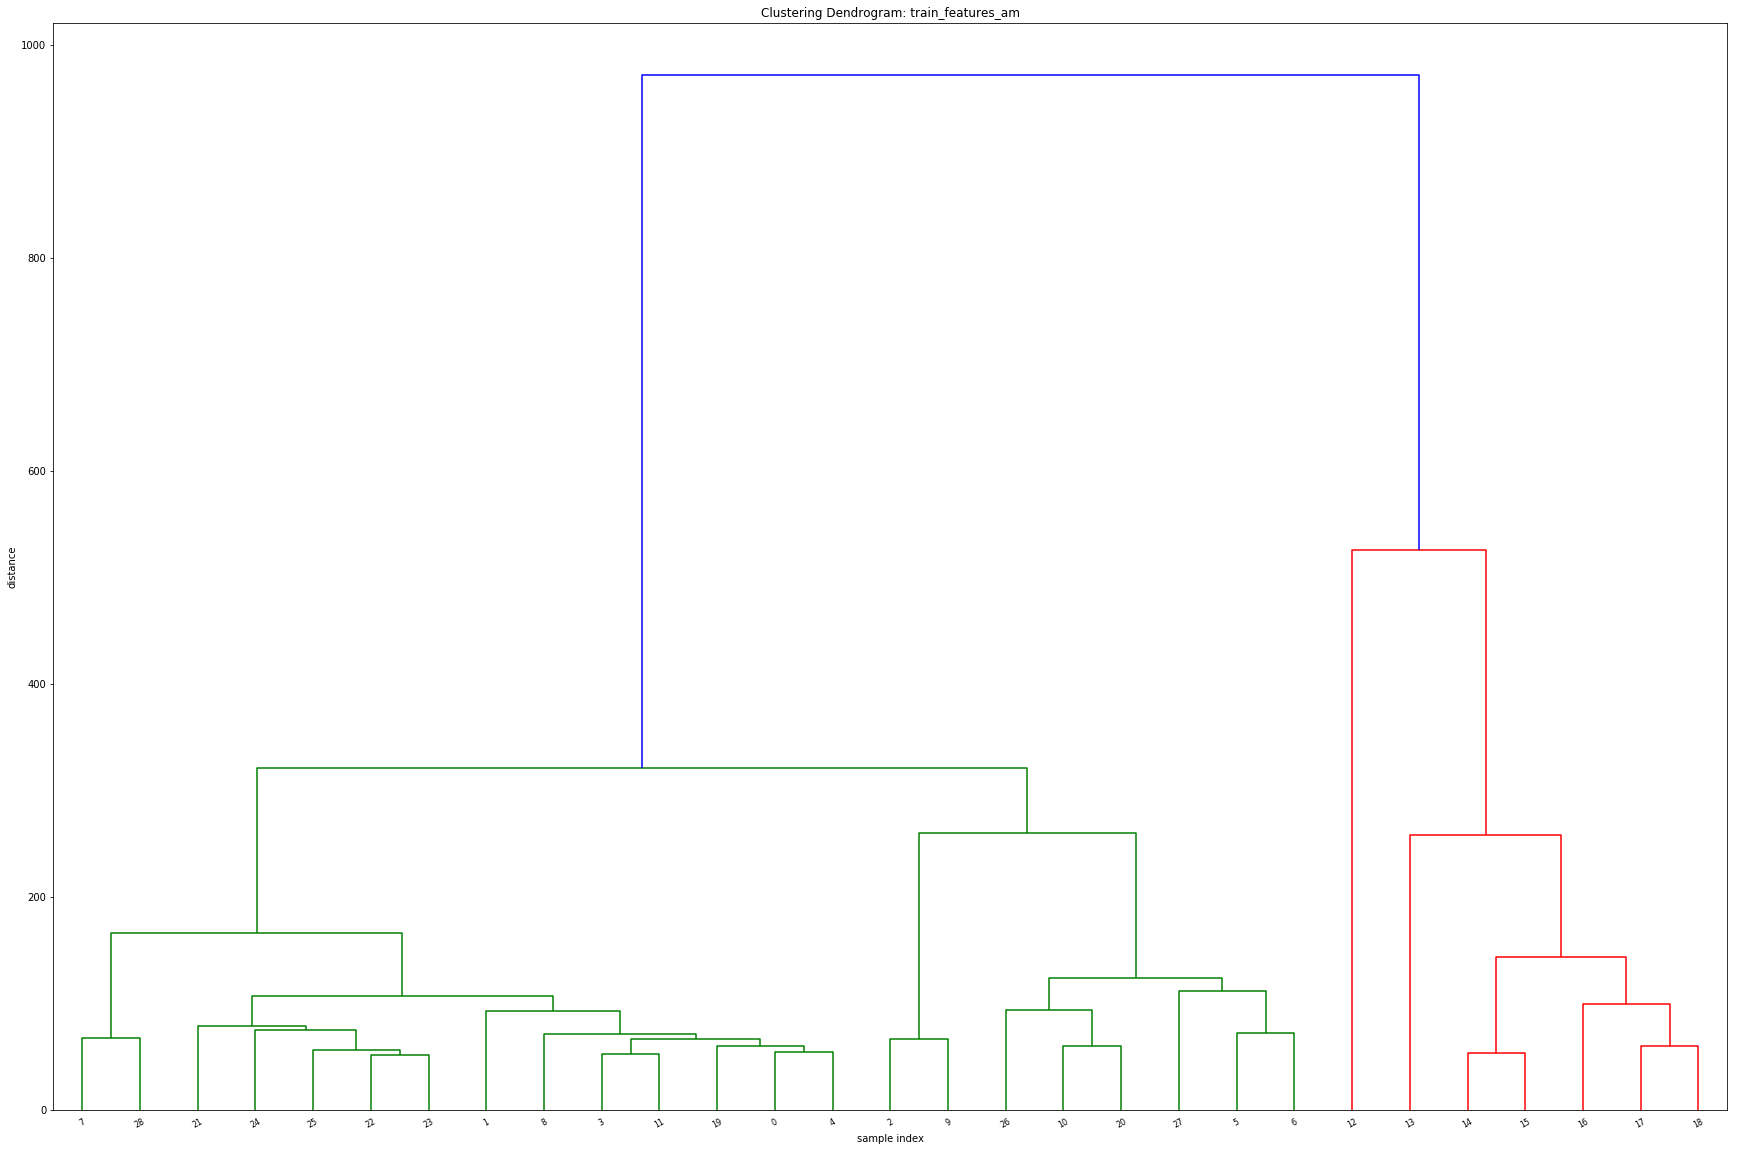

In [327]:
# 对test_features进行可视化
plt.figure(1, figsize=(30,20))
Z = linkage(train_features_am, 'ward')
plt.title('Clustering Dendrogram: train_features_am')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=29.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

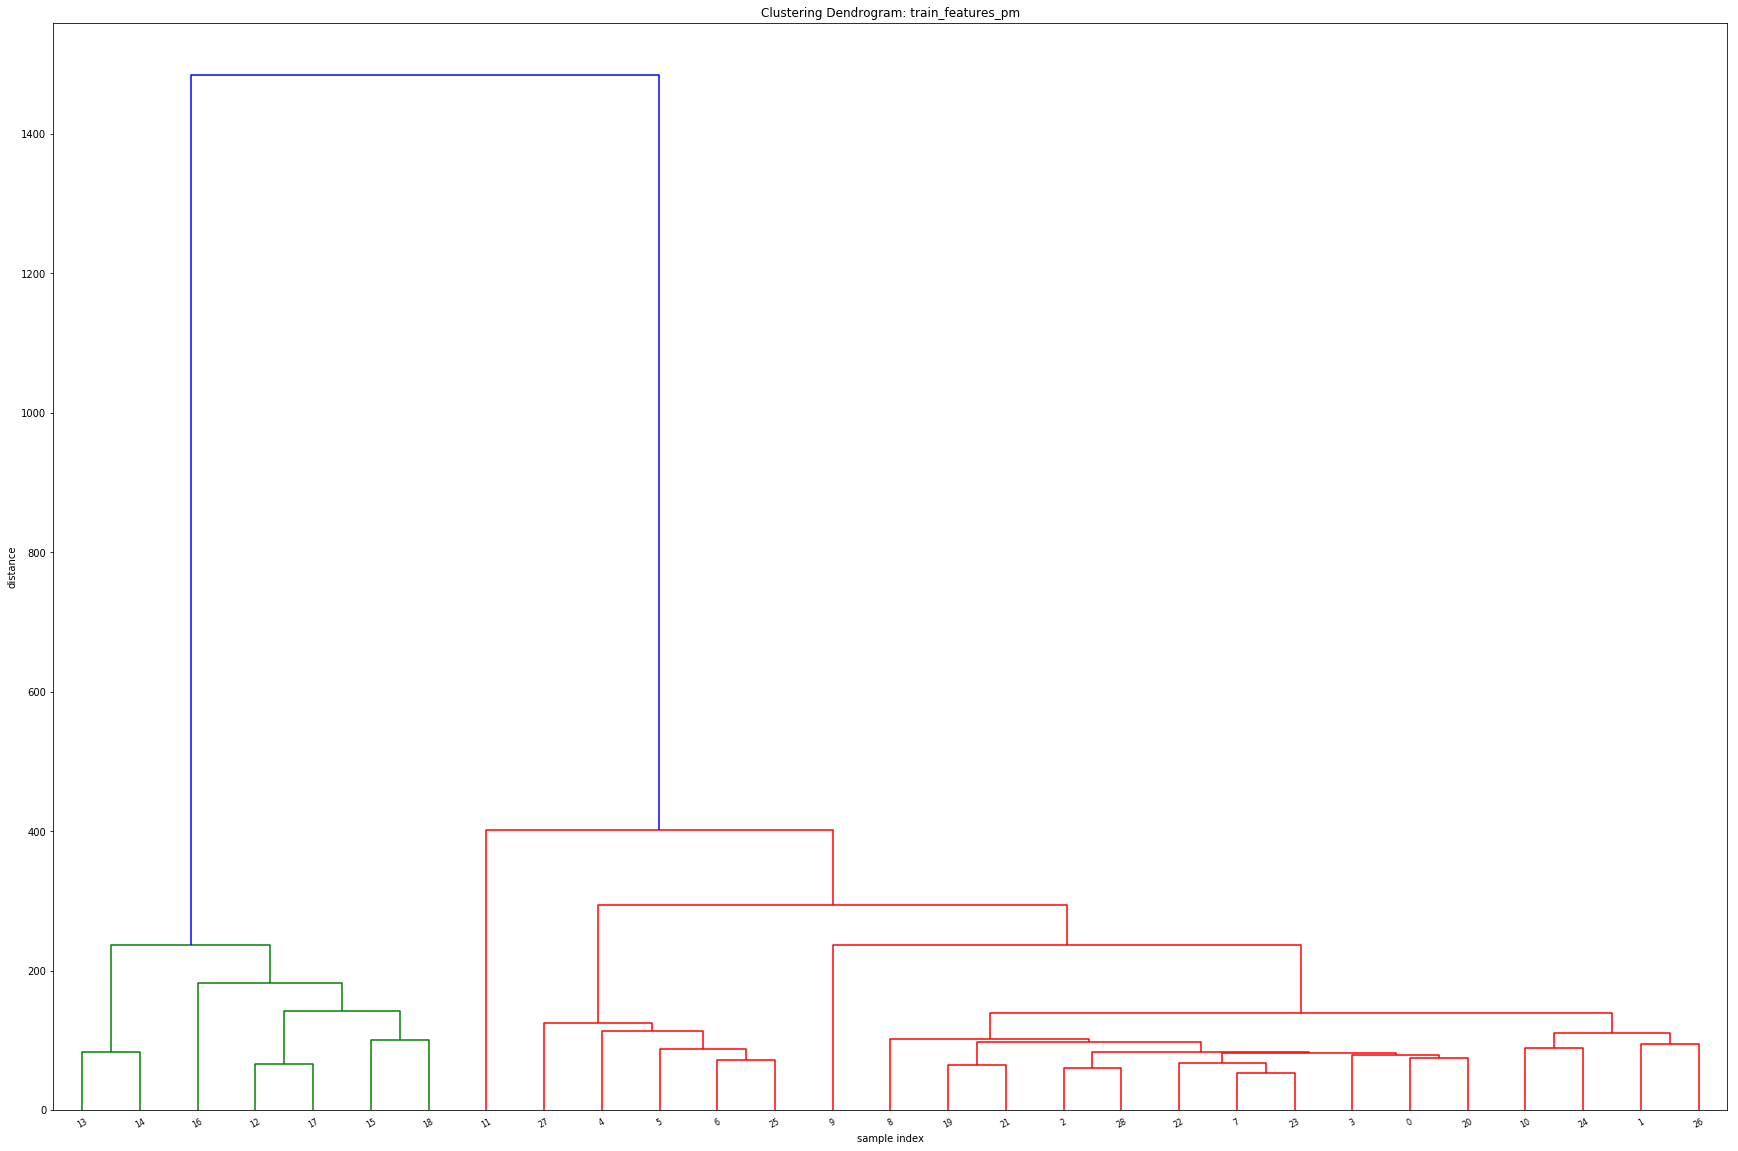

In [328]:
plt.figure(2, figsize=(30,20))
Z = linkage(train_features_pm, 'ward')
plt.title('Clustering Dendrogram: train_features_pm')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=29.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [333]:
# 类标签就是训练集的天数
kmeans_am = KMeans(n_clusters=14, random_state=0)
kmeans_am = kmeans_am.fit(train_features_am)
kmeans_pm = KMeans(n_clusters=14, random_state=0)
kmeans_pm = kmeans_pm.fit(train_features_pm)

train_labels_am = np.array(kmeans_am.labels_)
train_labels_pm = np.array(kmeans_pm.labels_)

In [334]:
print len(train_labels_am)
print len(train_labels_pm)
print train_labels_am
print train_labels_pm


29
29
[ 8 13  4  8  8 12 12  7  8  4  3  0  2  6  1  1 10 11 11  8  3  8  0  0  0
  0  9  5  7]
[ 6  6  6  6  2  9  9  6  6  4 13  3 11  5  5 10  8 11  1  0  6  6  0  6 13
  9  7 12  6]


In [335]:
pred_kms_am = np.array(kmeans_am.predict(test_features_am))
pred_kms_pm = np.array(kmeans_pm.predict(test_features_pm))

In [336]:
print pred_kms_am
print pred_kms_pm

[8 0 8 8 5 5 7]
[0 0 6 9 0 6 6]


In [338]:
# 得到KMean聚类
pred_day_am = list()
pred_day_pm = list()
for i in range(len(pred_kms_am)):
    p_am = pred_kms_am[i]
    p_pm = pred_kms_pm[i]
    pred_day_am.append(np.where(train_labels_am == p_am)[0])   
    pred_day_pm.append(np.where(train_labels_pm == p_pm)[0])

print len(pred_day_am)
print pred_day_pm

7
[array([19, 22]), array([19, 22]), array([ 0,  1,  2,  3,  7,  8, 20, 21, 23, 28]), array([ 5,  6, 25]), array([19, 22]), array([ 0,  1,  2,  3,  7,  8, 20, 21, 23, 28]), array([ 0,  1,  2,  3,  7,  8, 20, 21, 23, 28])]


In [339]:
pred_kmeans = pd.DataFrame(columns=['tollgate_id', 'direction',
                                    'time','volume'])
day_all = train_follow2h.time.dt.date
start_day = day_all.values[0]
test_start_day = test_prev2h.time.dt.date.values[0]
train_pd_am = pd.DataFrame()
train_pd_pm = pd.DataFrame()
train_pd = pd.DataFrame()

for i in range(len(pred_day_am)):
    pday_am, pday_pm = pred_day_am[i], pred_day_pm[i]
    for j in range(len(pday_am)):
        pd_am = pday_am[j]
        day_am = start_day + timedelta(days=pd_am)
        day_time_am = [datetime(day_am.year, day_am.month, day_am.day, 8,0,0),
                   datetime(day_am.year, day_am.month, day_am.day, 10,0,0)] 
        train_pd_am = train_pd_am.append(train_follow2h.loc[((train_follow2h.time >= day_time_am[0])
                               & (train_follow2h.time < day_time_am[1]))])
    for k in range(len(pday_pm)):
        pd_pm = pday_pm[k]
        day_time_pm = [datetime(day_pm.year, day_pm.month, day_pm.day, 17,0,0),
                   datetime(day_pm.year, day_pm.month, day_pm.day, 19,0,0)] 
        train_pd_pm = train_pd_pm.append(train_follow2h.loc[((train_follow2h.time >= day_time_pm[0])
                               & (train_follow2h.time < day_time_pm[1]))])
    day_need  = test_start_day+timedelta(days=i)
    train_pd = train_pd_am.append(train_pd_pm, ignore_index=True)
    train_pd.time = train_pd.time.apply(
      lambda dt: datetime(day_need.year, day_need.month, day_need.day,
                         dt.hour, dt.minute, 0))
    train_pd =  train_pd.groupby(['tollgate_id', 'direction','time']).mean()
    train_pd = train_pd.reset_index()
    pred_kmeans = pred_kmeans.append(train_pd, ignore_index=True)

pred_kmeans.time = pd.to_datetime(pred_kmeans.time)
pred_kmeans['tollgate_id'] = pred_kmeans['tollgate_id'].astype(int)
pred_kmeans['direction'] = pred_kmeans['direction'].astype(int)

In [340]:
print pred_kmeans.shape[0]
print pred_kmeans.time.dtype
pred_kmeans.head(20)

420
datetime64[ns]


,tollgate_id,direction,time,volume
0,1,0,2016-10-18 08:00:00,47.166667
1,1,0,2016-10-18 08:20:00,51.666667
2,1,0,2016-10-18 08:40:00,50.166667
3,1,0,2016-10-18 09:00:00,46.333333
4,1,0,2016-10-18 09:20:00,48.833333
5,1,0,2016-10-18 09:40:00,47.166667
6,1,0,2016-10-18 17:00:00,42.000000
7,1,0,2016-10-18 17:20:00,26.000000
8,1,0,2016-10-18 17:40:00,26.000000
9,1,0,2016-10-18 18:00:00,29.000000


In [341]:
# 生成对应格式的输出csv文件
test_pred = pred_kmeans
start_time= test_pred.time
end_time = start_time.apply(lambda dt: dt + timedelta(minutes=20))
test_pred['time']  = '['+ start_time.astype(str) + ',' + end_time.astype(str) + ')'
test_pred = test_pred.rename_axis({'time':'time_window'}, axis='columns')
test_pred = test_pred.reindex_axis(['tollgate_id', 'time_window', 'direction', 'volume'],
                            axis='columns')
test_pred.to_csv('results/task2_kmeans.csv', index=False)


In [342]:
print test_pred.shape[0]
test_pred.head(20)

420


,tollgate_id,time_window,direction,volume
0,1,"[2016-10-18 08:00:00,2016-10-18 08:20:00)",0,47.166667
1,1,"[2016-10-18 08:20:00,2016-10-18 08:40:00)",0,51.666667
2,1,"[2016-10-18 08:40:00,2016-10-18 09:00:00)",0,50.166667
3,1,"[2016-10-18 09:00:00,2016-10-18 09:20:00)",0,46.333333
4,1,"[2016-10-18 09:20:00,2016-10-18 09:40:00)",0,48.833333
5,1,"[2016-10-18 09:40:00,2016-10-18 10:00:00)",0,47.166667
6,1,"[2016-10-18 17:00:00,2016-10-18 17:20:00)",0,42.000000
7,1,"[2016-10-18 17:20:00,2016-10-18 17:40:00)",0,26.000000
8,1,"[2016-10-18 17:40:00,2016-10-18 18:00:00)",0,26.000000
9,1,"[2016-10-18 18:00:00,2016-10-18 18:20:00)",0,29.000000
